# Projeto

## Data Profilling

## Dimensionality
1. Number of dimensionalities corresponds to number of observations taken (length of the Series)
2. Plot the dara at the most atomic granularity to look for regularities (repetitions) in the data

In [1]:
import pandas as pd
import numpy as np
import dslabs_functions as dslabs
from matplotlib.pyplot import figure, show, subplots, plot, legend, savefig
from matplotlib.axes import Axes
from matplotlib.figure import Figure

Index(['Total'], dtype='object')
Inferred frequency of the DateTimeIndex:  15T
Nr. Records =  2976
First timestamp 2023-10-01 00:00:00
Last timestamp 2023-10-31 23:45:00


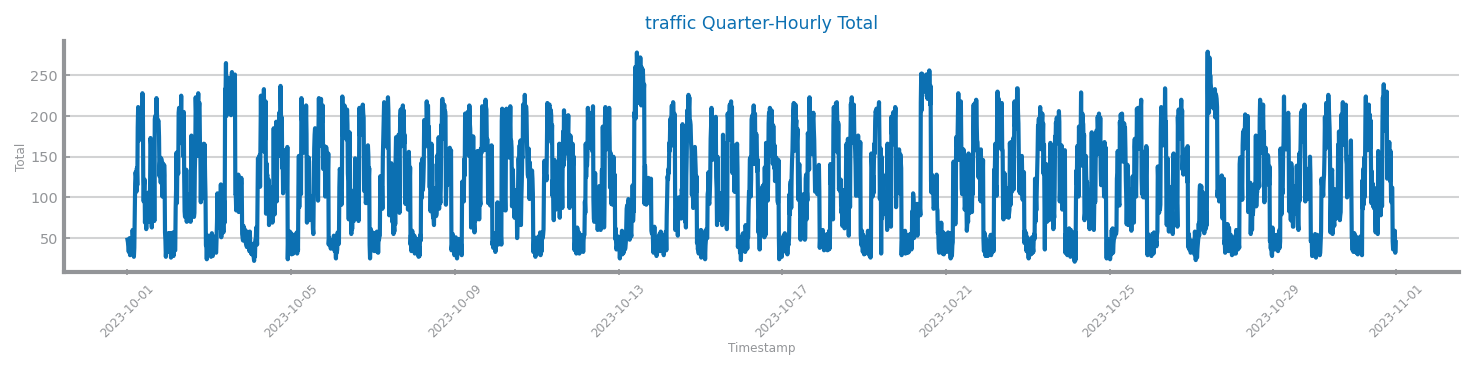

In [2]:
### Plotting UNIVARIATE Time Series
file_tag = "traffic"
target = "Total"
index="Timestamp"
### ordenar dados no csv ou nao e preciso??? last timestamp esta mal pq dados no csv nao estao ordenados por data
original_data: pd.DataFrame = pd.read_csv(
    "forecast_traffic_single.csv",
    index_col="Timestamp",
    sep=",",
    decimal=".",
    parse_dates=True,
    infer_datetime_format=True,
)

print(original_data.columns)

### Sort 'TimeStamp' Ascending
original_data.sort_index(inplace=True)
original_data.index = pd.to_datetime(original_data.index)
original_data.to_csv("sorted_forecast_traffic.csv")
series: pd.Series = original_data[target]

# Output the inferred frequency
inferred_freq = pd.infer_freq(series.index)
print("Inferred frequency of the DateTimeIndex: ", inferred_freq)

print("Nr. Records = ", series.shape[0])
print("First timestamp", series.index[0])
print("Last timestamp", series.index[-1])

figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2))
dslabs.plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} Quarter-Hourly {target}",
)
savefig("../forecasting_services/data_profilling_images/first_granularity.png", bbox_inches='tight')
show()


### Conclusions
1. *There are some intervals where the consumption is constant and around xxx.*
2. *There is a kind of a pattern that approximately repeats (weekly)*
3. *Series seems to show a small (reduction/up) along the month of October*

## Granularity
- try other aggregations
1. Aggregating by days, kind of a smoothing, because we use mean as aggregation function -> resulting in a smoother version of the original time series, with less noise
2. By Days, Weeks and Monthly

744
-----
186
-----
93
-----
31
-----
6
-----


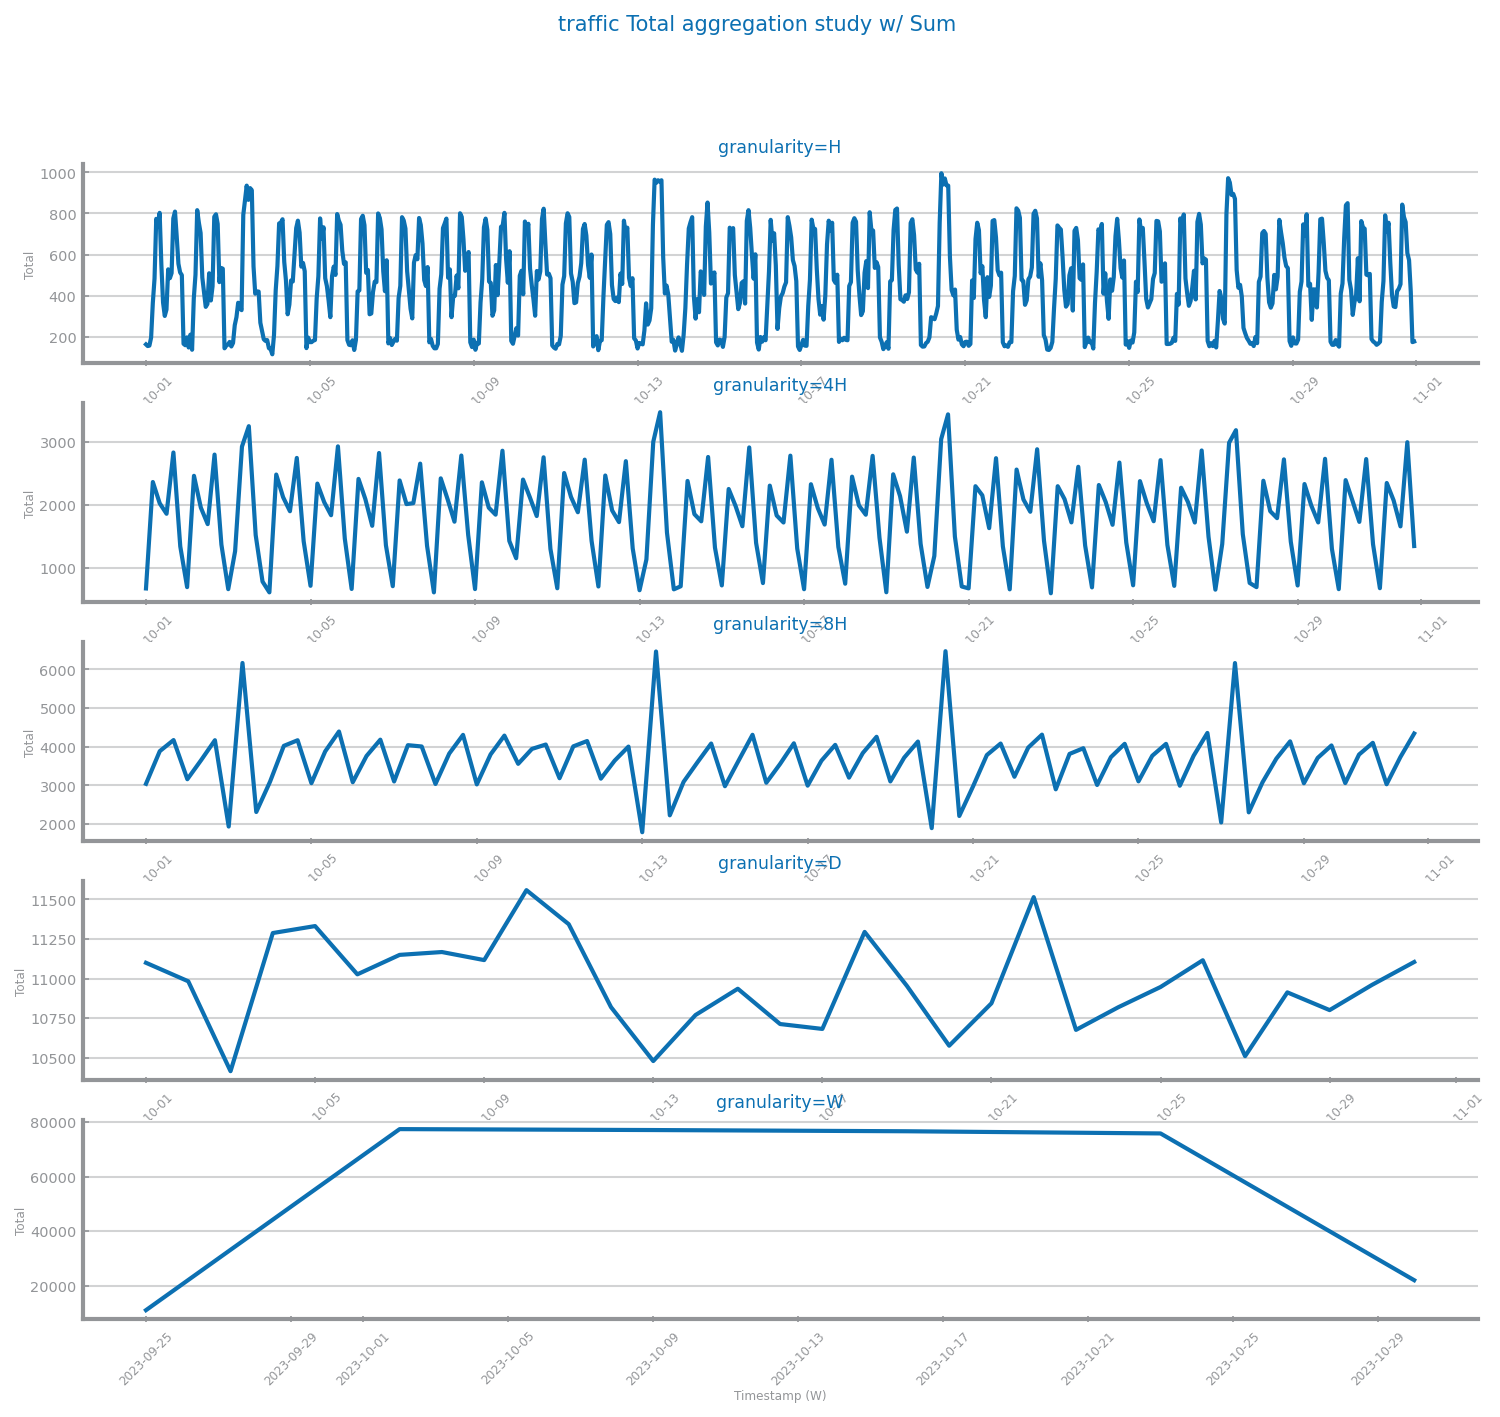

In [3]:
grans = ["H", "4H", "8H", "D", "W"]
ss_grouped_hour = dslabs.ts_aggregation_by(series, "H", "sum")
ss_days = dslabs.ts_aggregation_by(series, "D", "sum")
ss_weeks = dslabs.ts_aggregation_by(series, "W", "sum")
fig, axs = subplots(len(grans), 1, figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2 * len(grans)))
fig.suptitle(f"{file_tag} {target} aggregation study w/ Sum")

for i, gran in enumerate(grans):
    if gran == "4H":
        grouped_sum = []
        indices = []
        for j in range(0, len(original_data), 16):
            sum_value = original_data.iloc[j:j+16]['Total'].sum()
            grouped_sum.append(sum_value)
            indices.append(original_data.index[j])
        ss_grouped_4 = pd.Series(grouped_sum, index=indices)
        ss = ss_grouped_4
    elif gran == "8H":
        grouped_sum = []
        indices = []
        for j in range(0, len(original_data), 32):
            sum_value = original_data.iloc[j:j+32]['Total'].sum()
            grouped_sum.append(sum_value)
            indices.append(original_data.index[j])
        ss_grouped_8 = pd.Series(grouped_sum, index=indices)
        ss = ss_grouped_8
    else:
        ss = dslabs.ts_aggregation_by(series, gran, "sum")
    
    print(len(ss))
    print("-----")
    dslabs.plot_line_chart(
        ss.index.to_list(),
        ss.to_list(),
        ax=axs[i],
        xlabel=f"{ss.index.name} ({grans[i]})",
        ylabel=target,
        title=f"granularity={grans[i]}",
    )
savefig("../forecasting_services/data_profilling_images/granularity_study.png", bbox_inches='tight')
show()

### Conclusions
1. (daily) In this new version, the cyclic behaviour is not so noticeable, as we have seen before - it does not show any cyclic behavior as before -
2. (weekly) The traffic is reduced almost linearly until the 23rd of October and goes to the the levels of the beginning of the month by the end of the month,we dont have more information related to other months but we can presume that it has a monthly cycle (values in the beginning are almost the same as in the end)// people use more personal vehicles in the beginning of the month because they received the paycheck and as the times goes on(progride) are more cautious about the money they are spending resulting in less traffic
3. (monthly) It gives nothing, we only have information related to the month of October
4. both daily and weekly confirms the lack of stationarity in the time series. It's mean is not constant along time. In particular, is possible to identify very different values of traffic per day and week

## Distribution
- We have considered centrality , trends and distribution of the variable, different aggregations may show different distributions

### Using Mean to Represent Weekly pattern because the rest it's the same

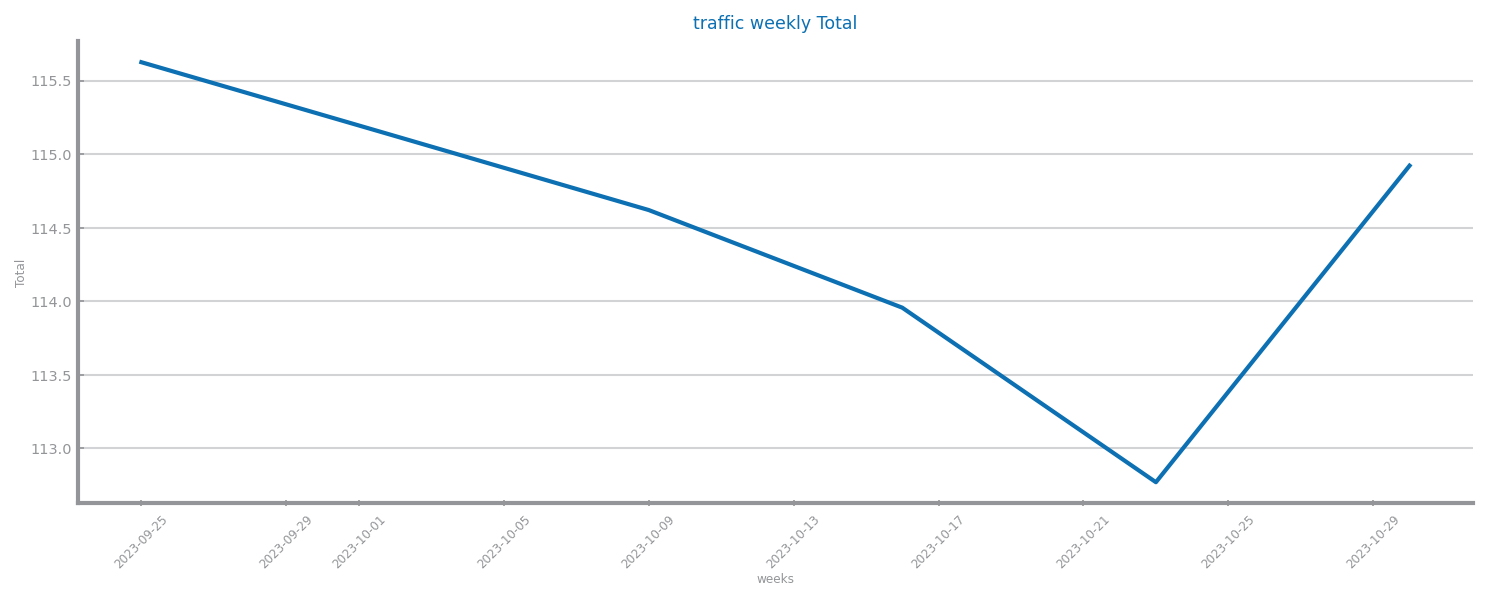

In [4]:
### "Remember that this is possible only when the variable keeps its semantic untouched, as is the case for consumptions."
###  relating to aggregating with sum instead of mean, how do we know that the variables keeps its
###  semantic untouched
ss_week_sum: pd.Series = dslabs.ts_aggregation_by(series, gran_level="W", agg_func="mean")

figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT))
dslabs.plot_line_chart(
    ss_week_sum.index.to_list(),
    ss_week_sum.to_list(),
    xlabel="weeks",
    ylabel=target,
    title=f"{file_tag} weekly {target}",
)
savefig("../forecasting_services/data_profilling_images/weekly_but_sum", bbox_inches='tight')
show()

### Conclusions (se fosse a soma)
1. note difference of scale for the total and the smoother transitions between periods

### 5-number summary
- Simplest way to analyze our variable's distribution is through the 5-number summary, and visualize it through boxplots

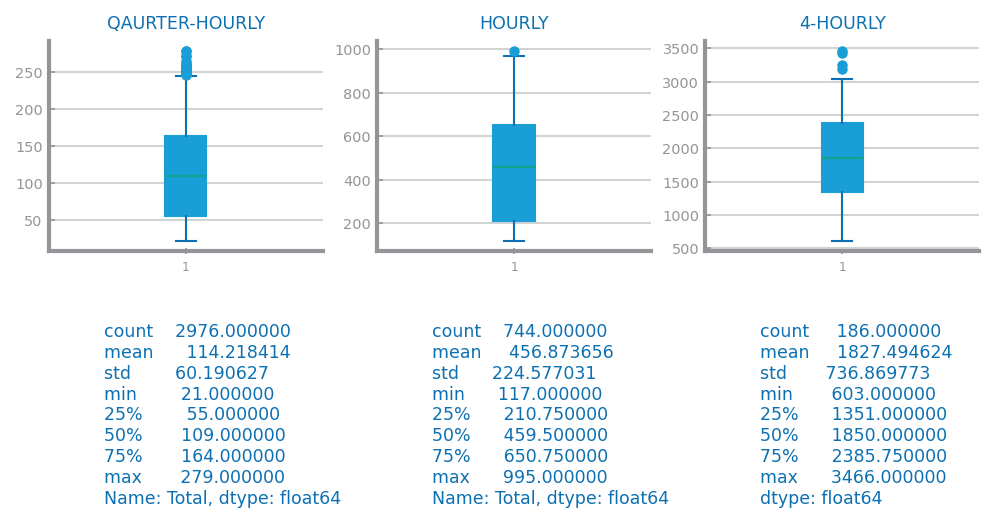

In [5]:
fig: Figure
axs: np.array
fig, axs = subplots(2, 3, figsize=(2 * dslabs.HEIGHT, dslabs.HEIGHT))
dslabs.set_chart_labels(axs[0, 0], title="QAURTER-HOURLY")
axs[0, 0].boxplot(series)
dslabs.set_chart_labels(axs[0, 1], title="HOURLY")
axs[0, 1].boxplot(ss_grouped_hour)
dslabs.set_chart_labels(axs[0, 2], title="4-HOURLY")
axs[0, 2].boxplot(ss_grouped_4)

axs[1, 0].grid(False)
axs[1, 0].set_axis_off()
axs[1, 0].text(0.2, 0, str(series.describe()), fontsize="small")

axs[1, 1].grid(False)
axs[1, 1].set_axis_off()
axs[1, 1].text(0.2, 0, str(ss_grouped_hour.describe()), fontsize="small")

axs[1, 2].grid(False)
axs[1, 2].set_axis_off()
axs[1, 2].text(0.2, 0, str(ss_grouped_4.describe()), fontsize="small")

savefig("../forecasting_services/data_profilling_images/distribution_boxplots", bbox_inches='tight')
show()

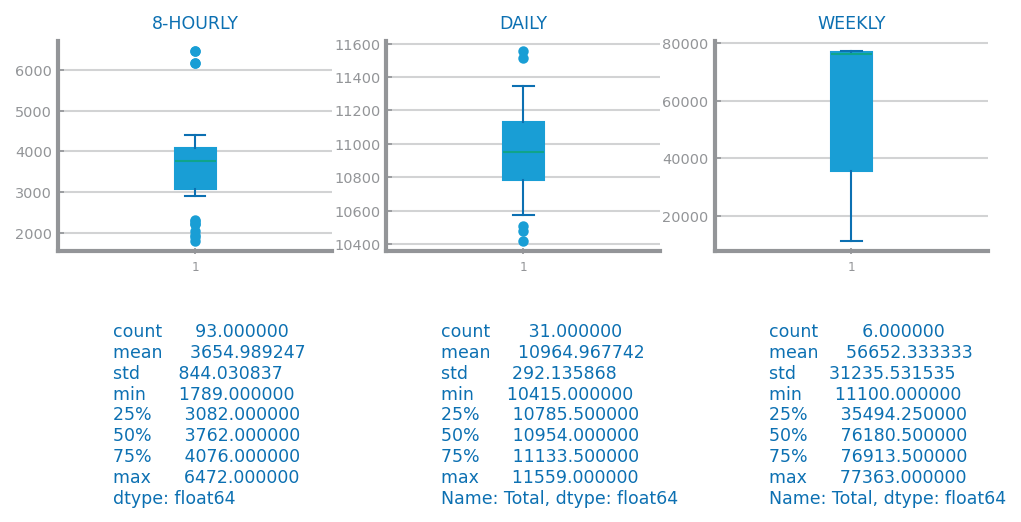

In [6]:
fig: Figure
axs: np.array
fig, axs = subplots(2, 3, figsize=(2 * dslabs.HEIGHT, dslabs.HEIGHT))

dslabs.set_chart_labels(axs[0, 0], title="8-HOURLY")
axs[0, 0].boxplot(ss_grouped_8)
dslabs.set_chart_labels(axs[0, 1], title="DAILY")
axs[0, 1].boxplot(ss_days)
dslabs.set_chart_labels(axs[0, 2], title="WEEKLY")
axs[0, 2].boxplot(ss_weeks)

axs[1, 0].grid(False)
axs[1, 0].set_axis_off()
axs[1, 0].text(0.2, 0, str(ss_grouped_8.describe()), fontsize="small")

axs[1, 1].grid(False)
axs[1, 1].set_axis_off()
axs[1, 1].text(0.2, 0, str(ss_days.describe()), fontsize="small")

axs[1, 2].grid(False)
axs[1, 2].set_axis_off()
axs[1, 2].text(0.2, 0, str(ss_weeks.describe()), fontsize="small")
savefig("../forecasting_services/data_profilling_images/distribution_boxplots_rest", bbox_inches='tight')
show()

## Variables distribution
- histograms to understand the variable distribution at different granularities

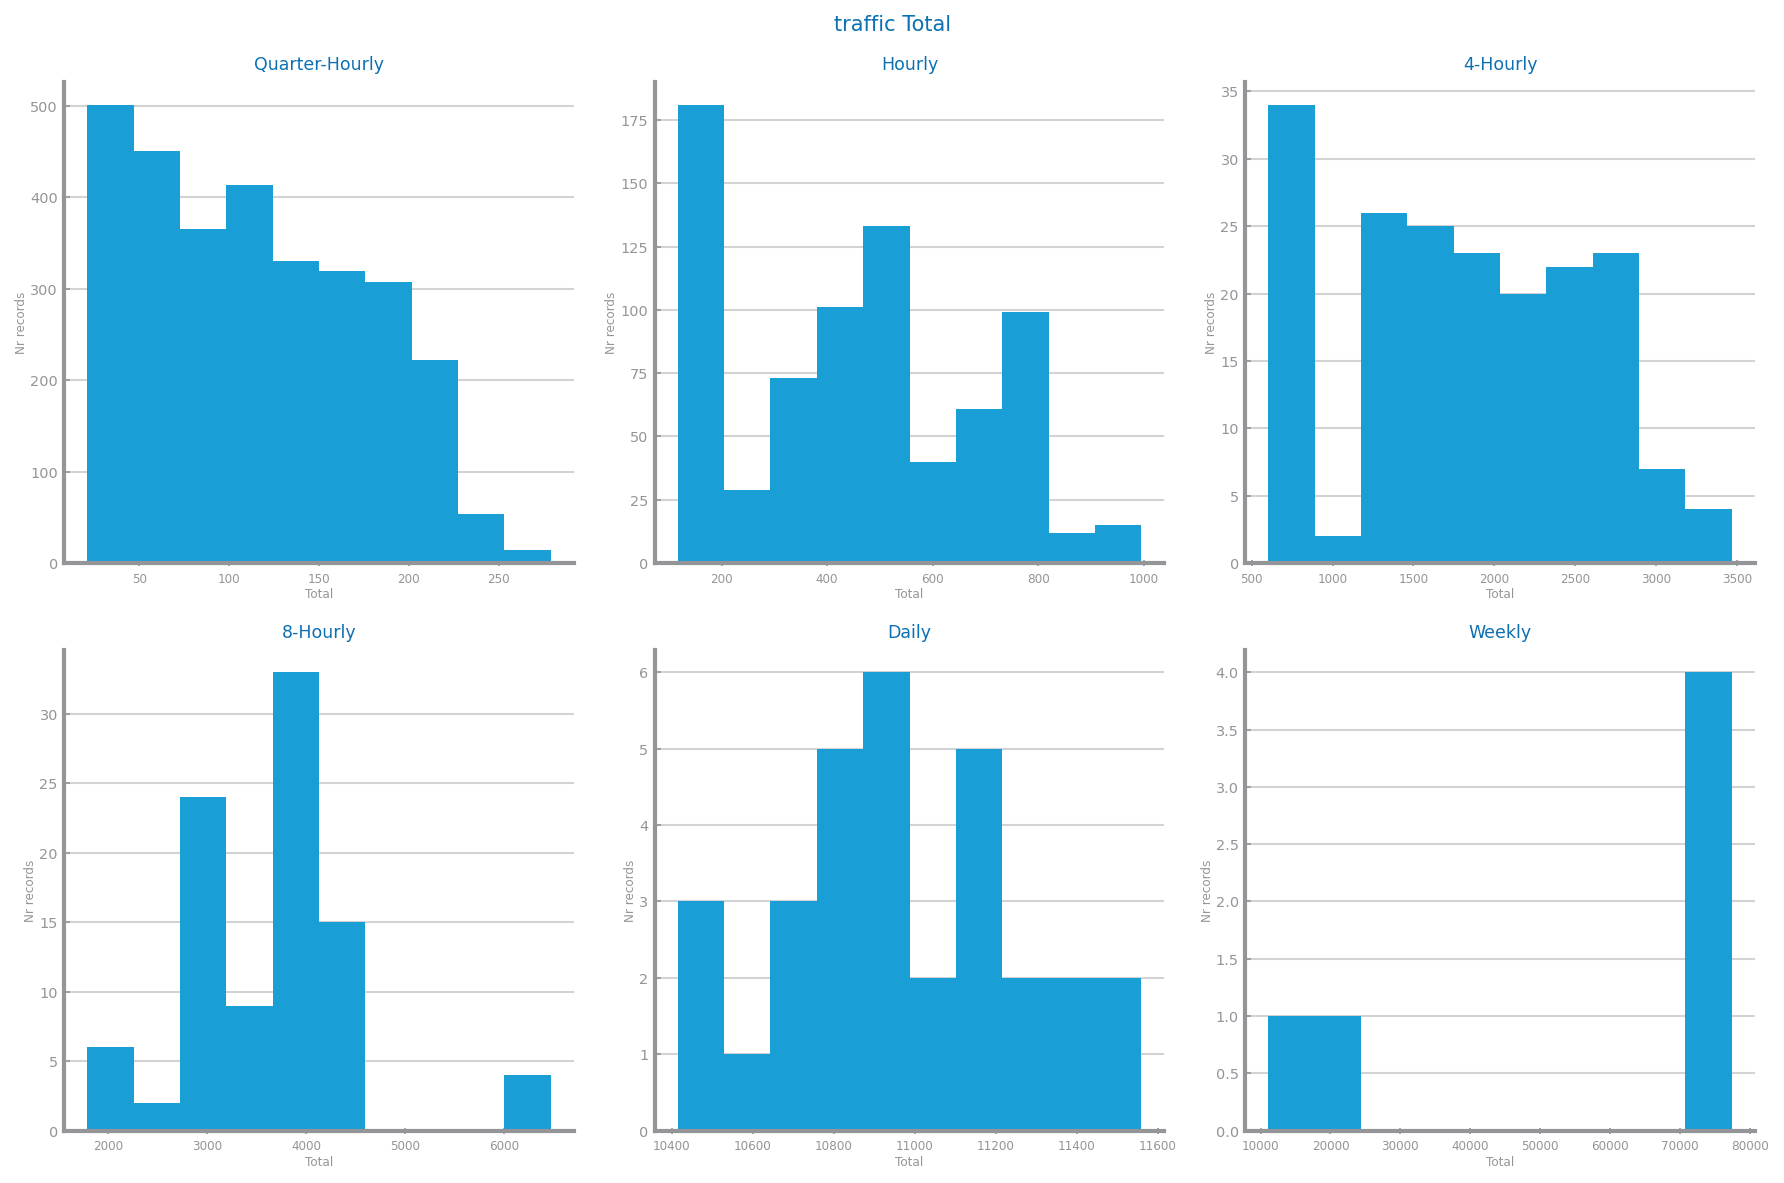

In [7]:
grans = [series, ss_grouped_hour, ss_grouped_4, ss_grouped_8, ss_days, ss_weeks]
gran_names = ["Quarter-Hourly", "Hourly", "4-Hourly", "8-Hourly", "Daily", "Weekly"]

# Create a figure with 2 rows and 3 columns
fig, axs = subplots(2, 3, figsize=(3 * dslabs.HEIGHT, 2 * dslabs.HEIGHT))
fig.suptitle(f"{file_tag} {target}")

# Iterate through the series and plot
for i, gran in enumerate(grans):
    row, col = divmod(i, 3)  # Determine the row and column position
    dslabs.set_chart_labels(axs[row, col], title=f"{gran_names[i]}", xlabel=target, ylabel="Nr records")
    axs[row, col].hist(gran.values)

# Adjust layout, save and show the figure
fig.tight_layout()
savefig("../forecasting_services/data_profilling_images/distribution_histograms.png", bbox_inches='tight')
show()

### Conclusoes
*distinguir entre distribuicoes nod diferentes niveis de granularidade*
1. In the histograms we recognize that our data follow approximately a normal distribution for the higher granularities. <br>But the same doesn't happen for the lowest ones. Those histograms show a multimodal distribution (not sure, verificar novamente), with at least two distinct modes.

## Autocorrelation

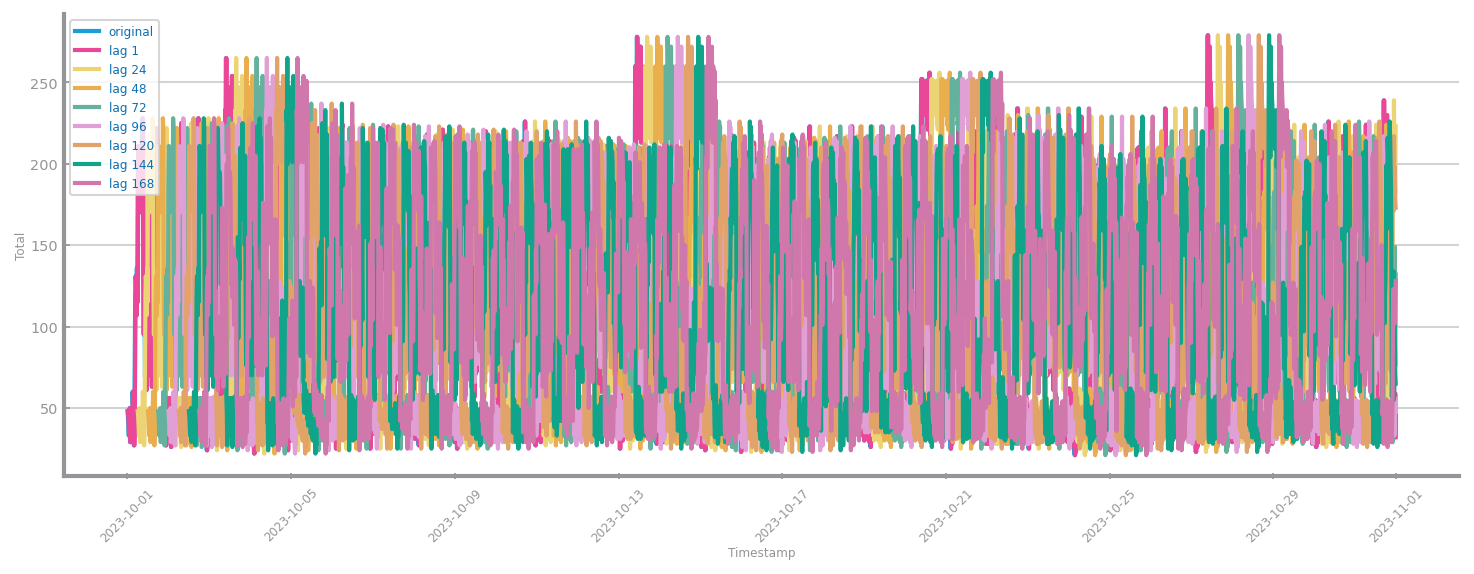

In [8]:
### Looking for Weekly patterns 168 hours. delta 8h
figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT))
lags = dslabs.get_lagged_series(series, 168, 24) ## 168 8 ou 20, 5
dslabs.plot_multiline_chart(series.index.to_list(), lags, xlabel=index, ylabel=target)
savefig("../forecasting_services/data_profilling_images/autocorrelation_lagplots", bbox_inches='tight')
show()

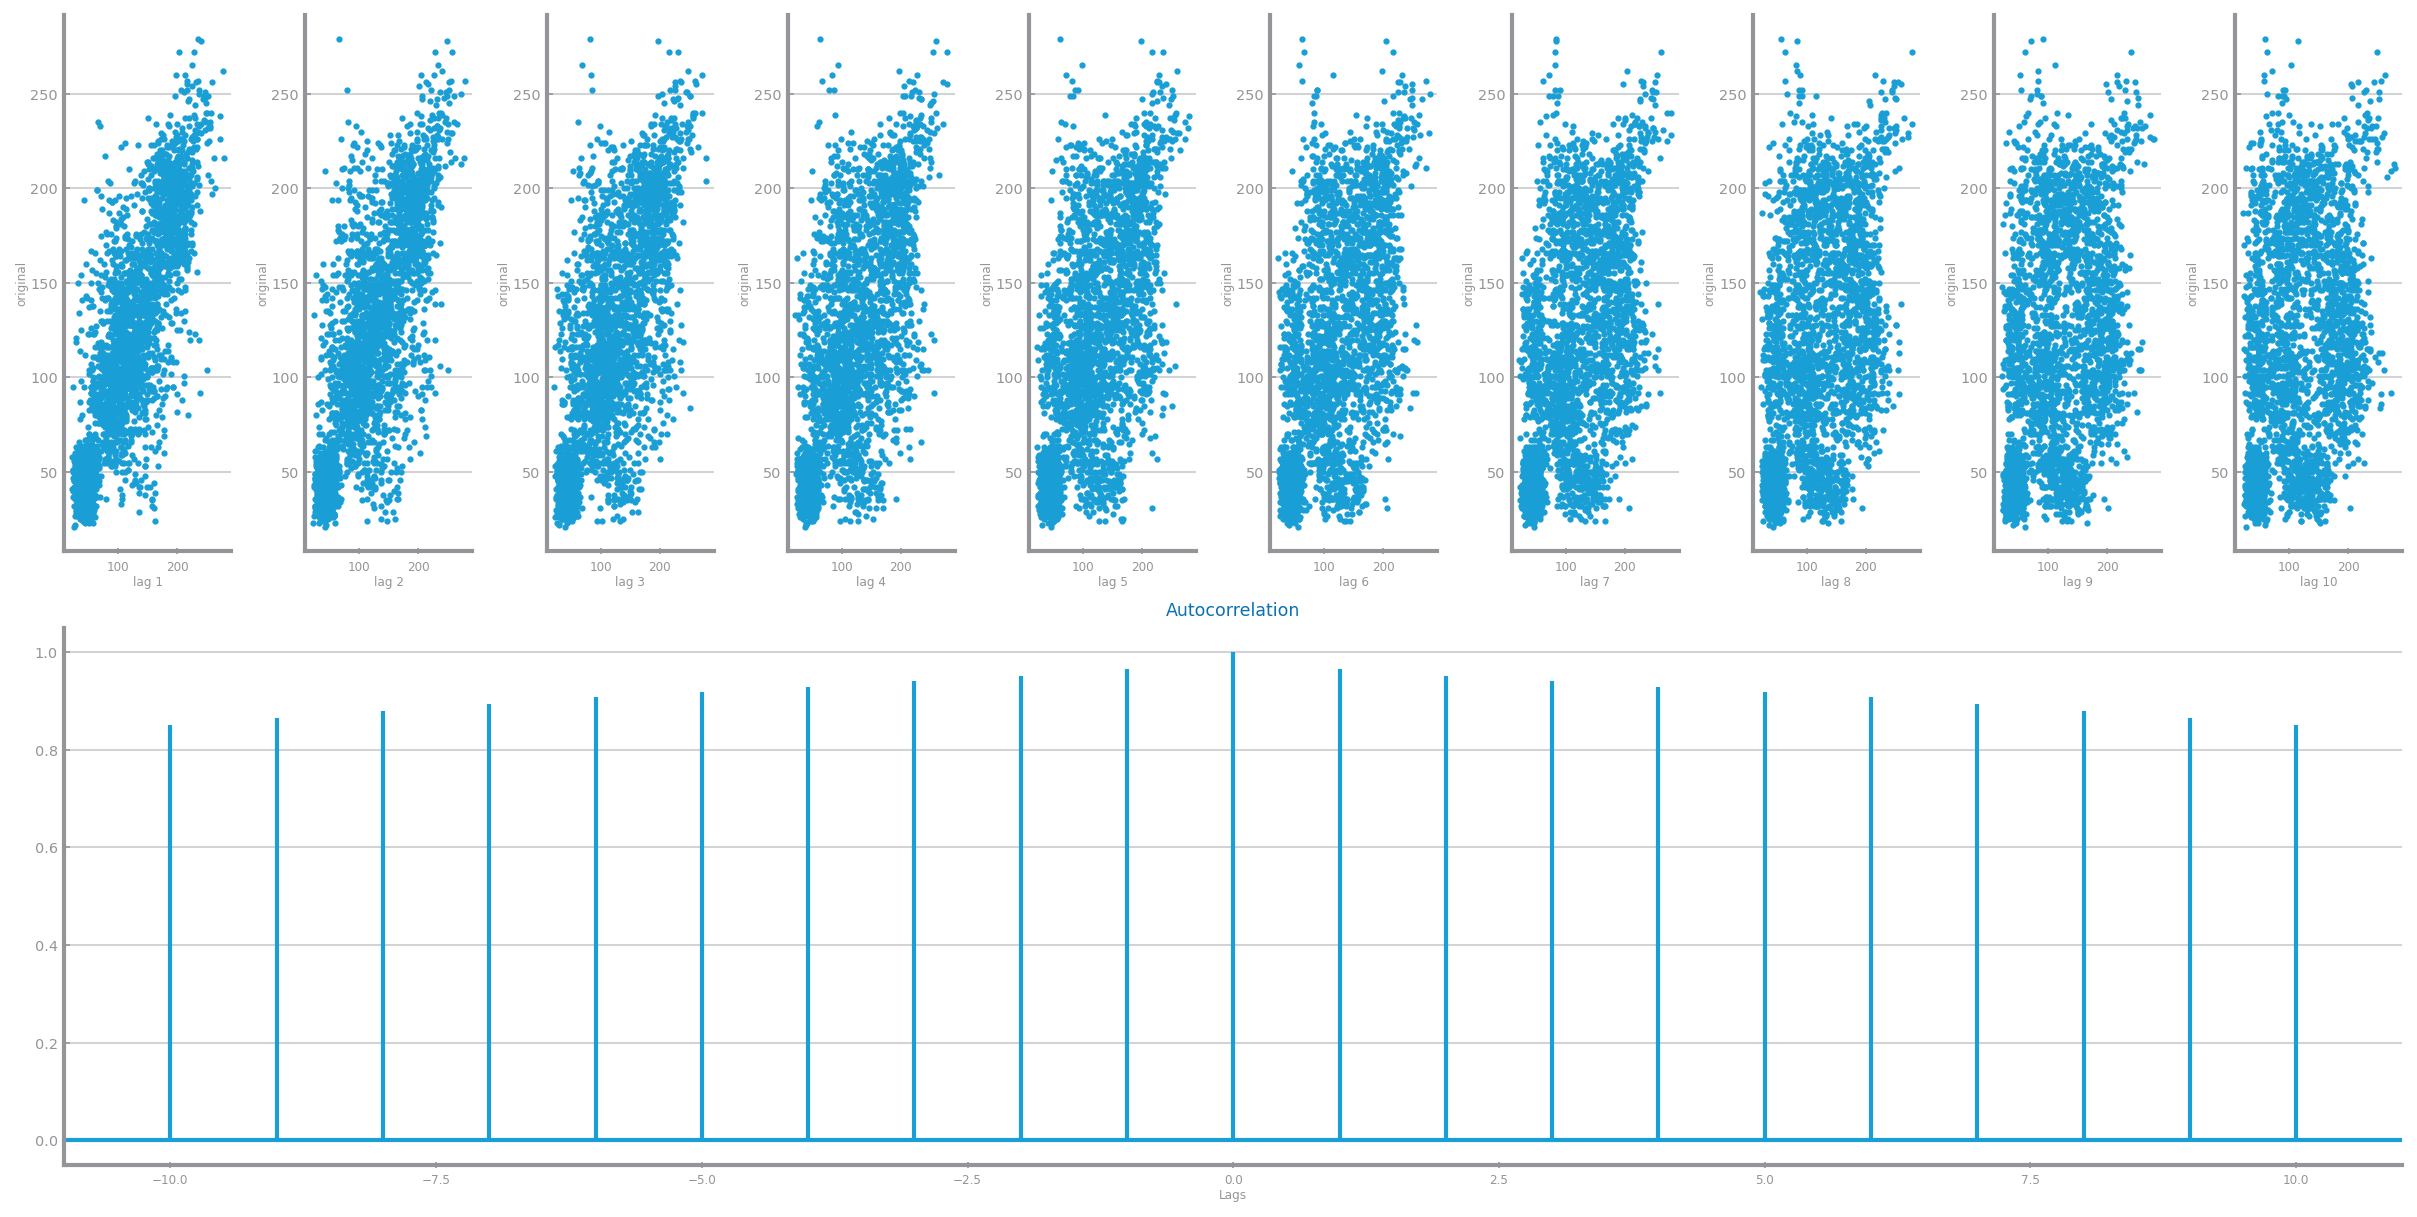

In [9]:
dslabs.autocorrelation_study(series, 10, 1)
savefig("../forecasting_services/data_profilling_images/autocorrelation_correlogram_1", bbox_inches='tight')
### no livro esta explicado como interpretar isto
### reduce delta for more detailed analysis

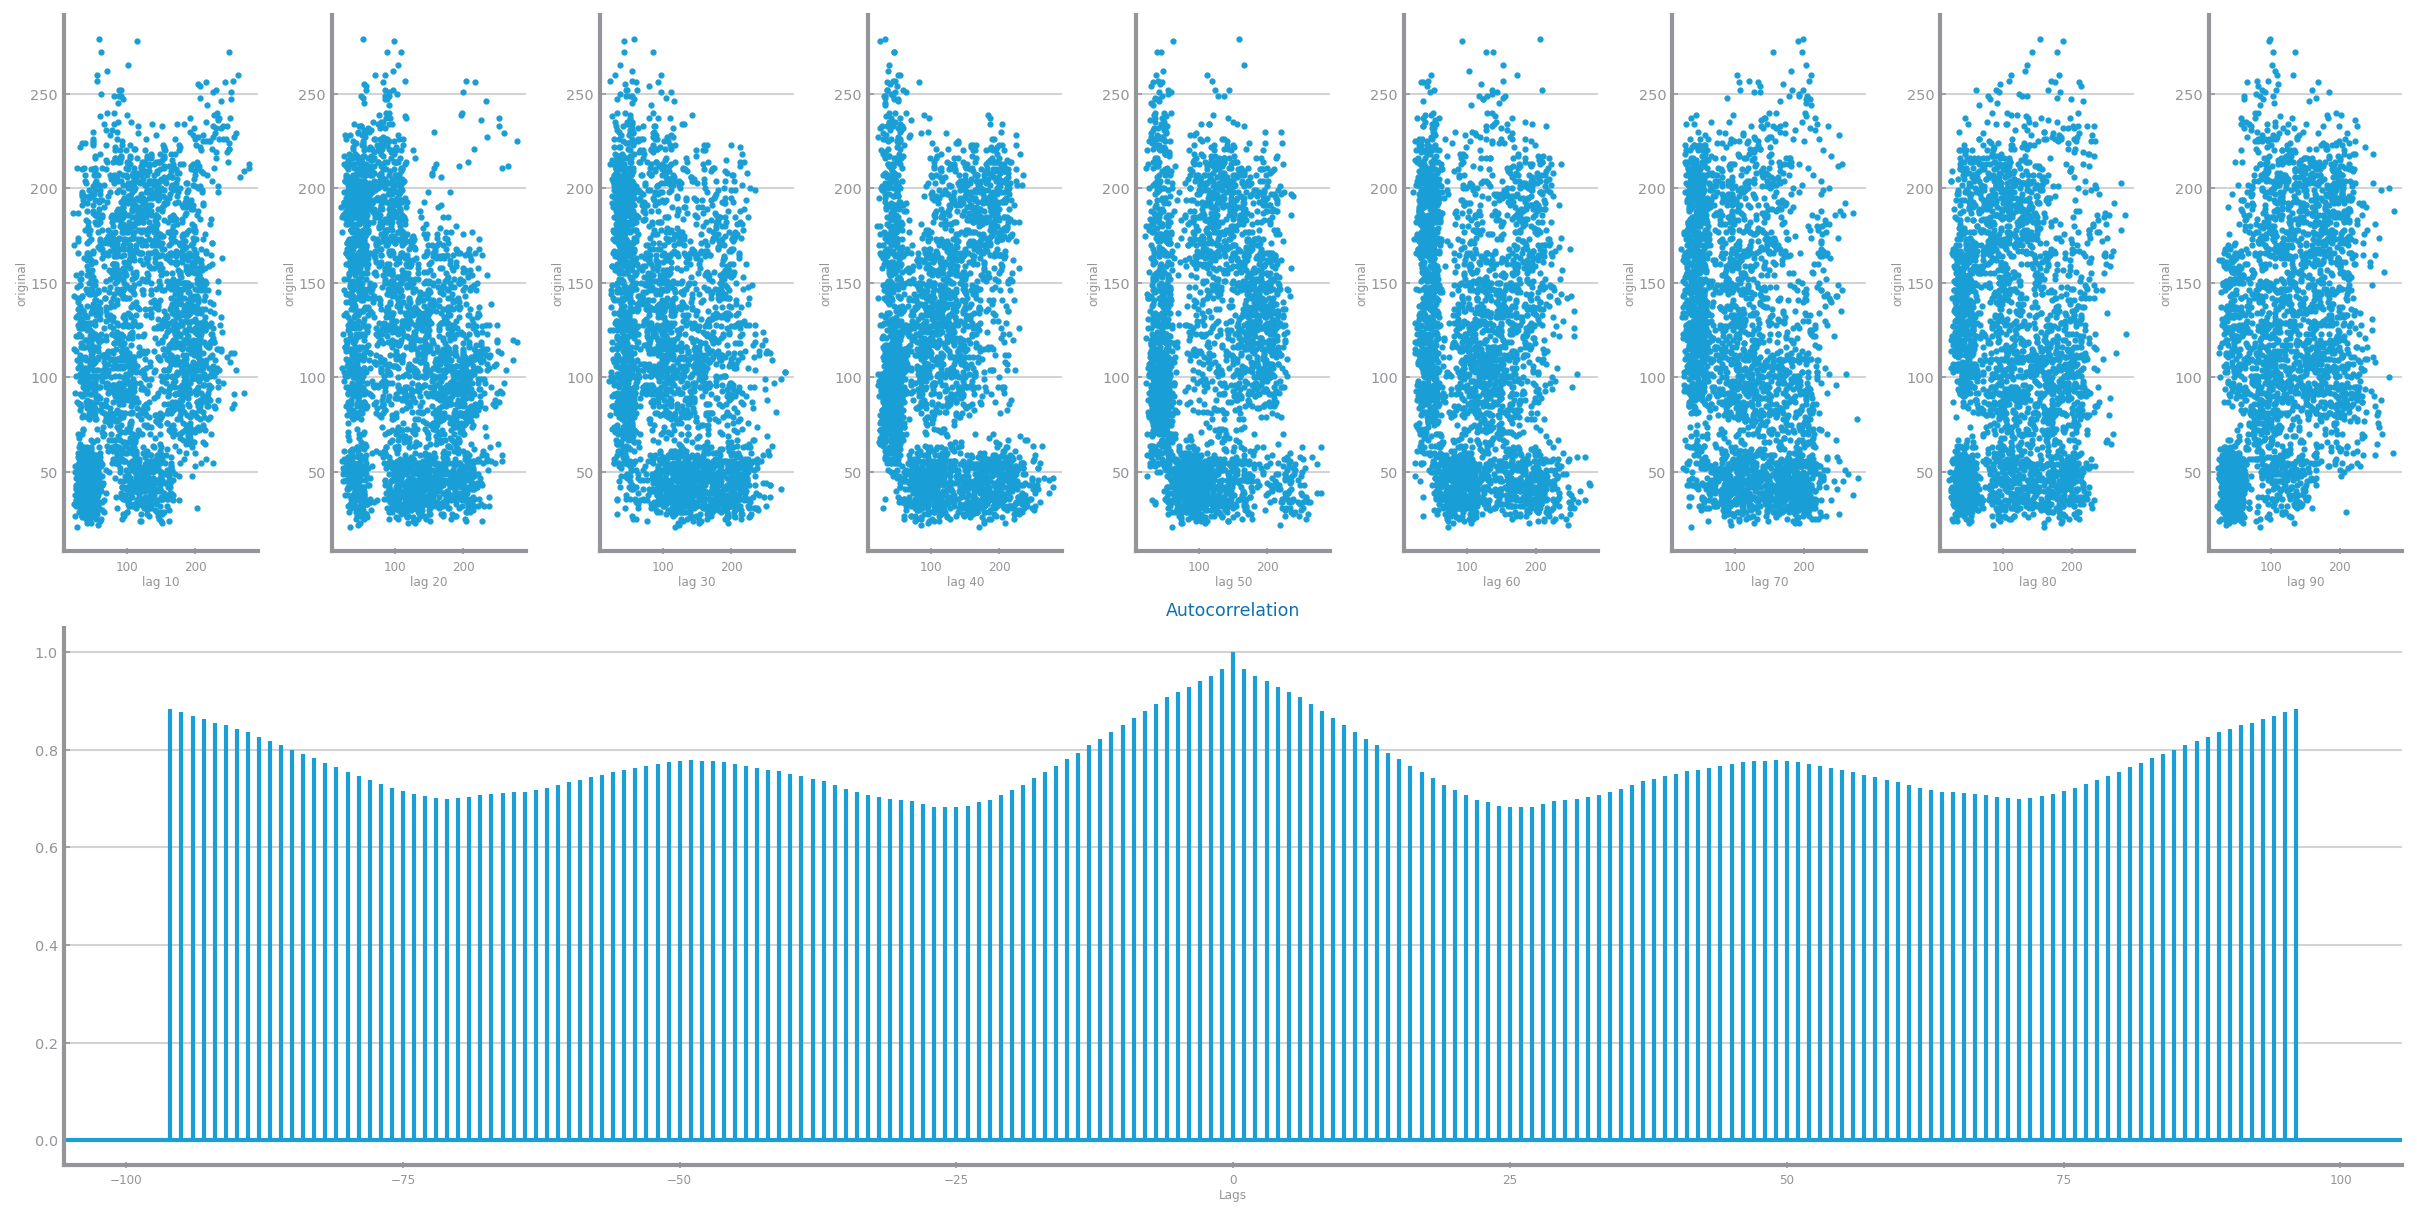

In [10]:
### apanhamos outro padrao para a autocorrelacao
### importance correlations within a day
dslabs.autocorrelation_study(series, 96, 10)
savefig("../forecasting_services/data_profilling_images/autocorrelation_correlogram_2", bbox_inches='tight')

## Stationarity
- Understand seasonality of a time series

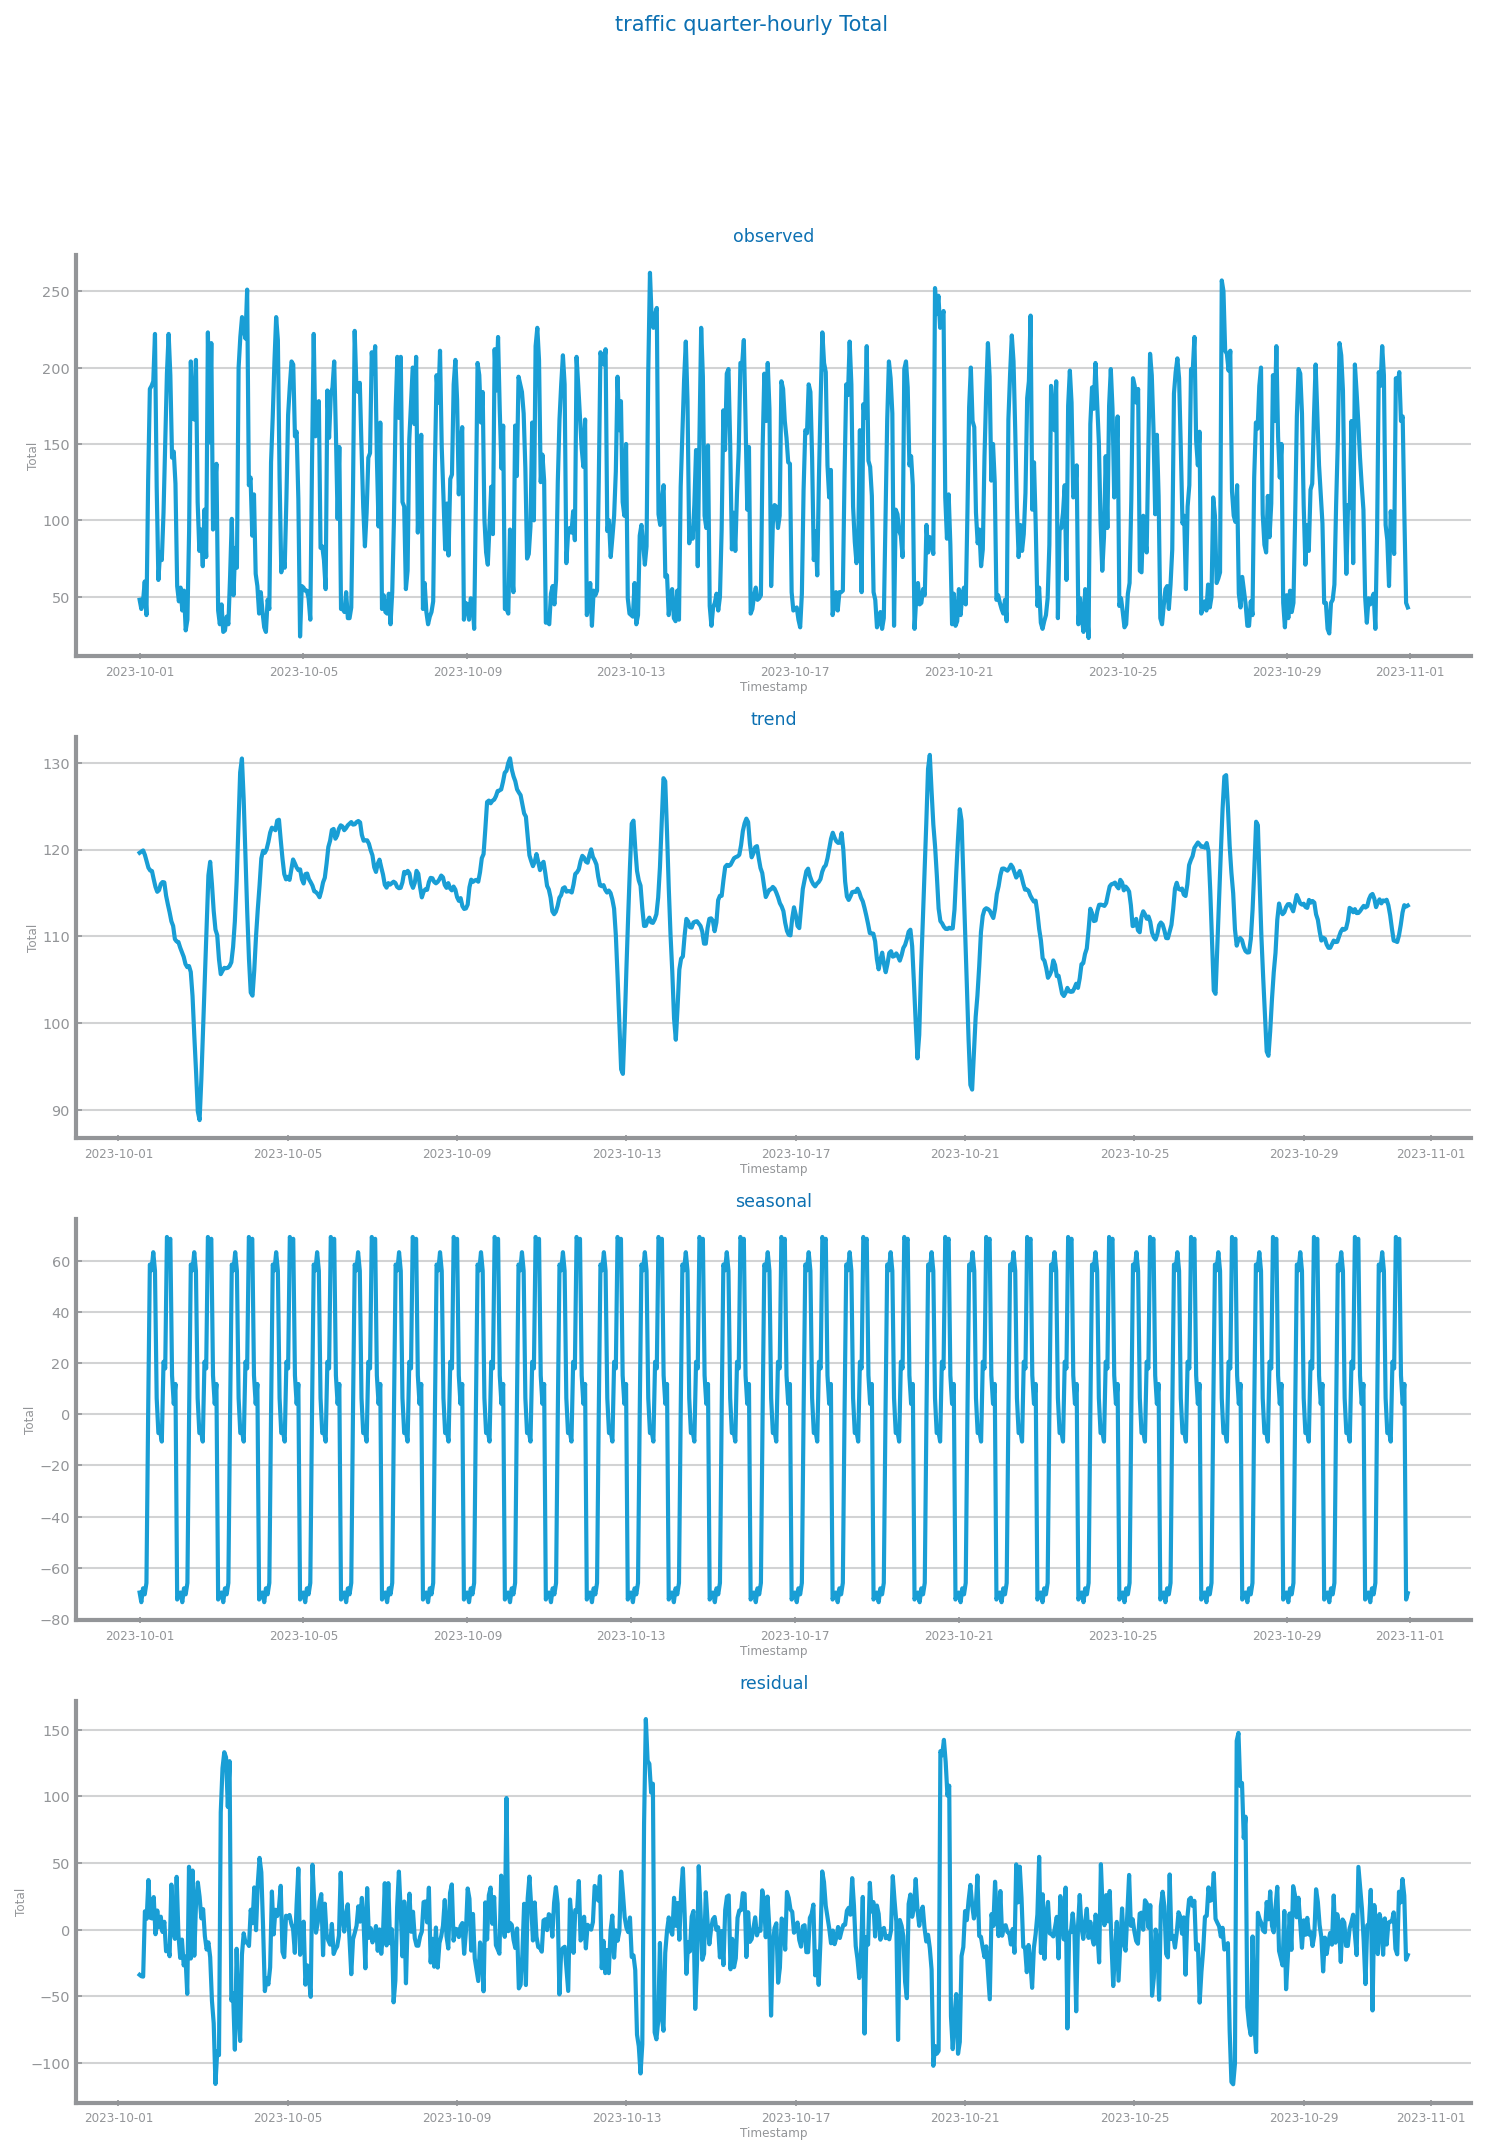

In [12]:
### sem isto da erro, perguntar
original_data = original_data.asfreq('H')

series: pd.Series = original_data[target]
dslabs.plot_components(
    series,
    title=f"{file_tag} quarter-hourly {target}",
    x_label=series.index.name,
    y_label=target,
)
savefig("../forecasting_services/data_profilling_images/components_study", bbox_inches='tight')
show()

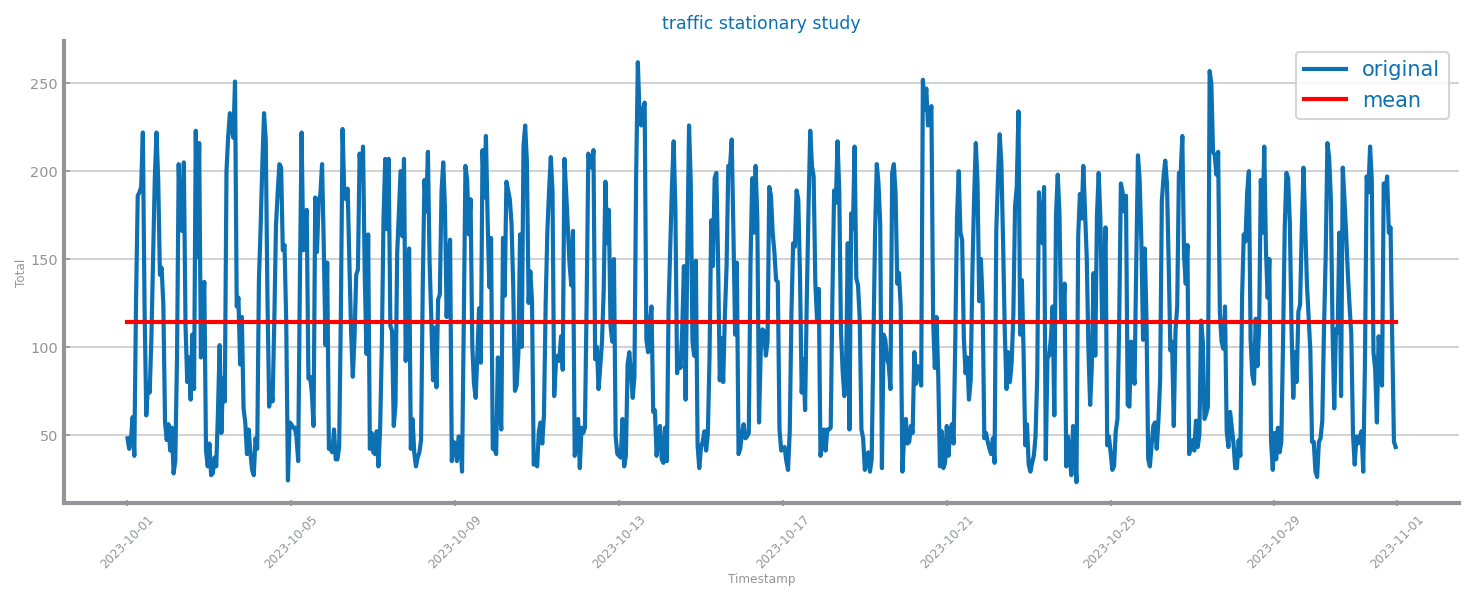

In [13]:
figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT))
dslabs.plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
)
n: int = len(series)
plot(series.index, [series.mean()] * n, "r-", label="mean")
legend()
savefig("../forecasting_services/data_profilling_images/stationarity_study_1", bbox_inches='tight')
show()

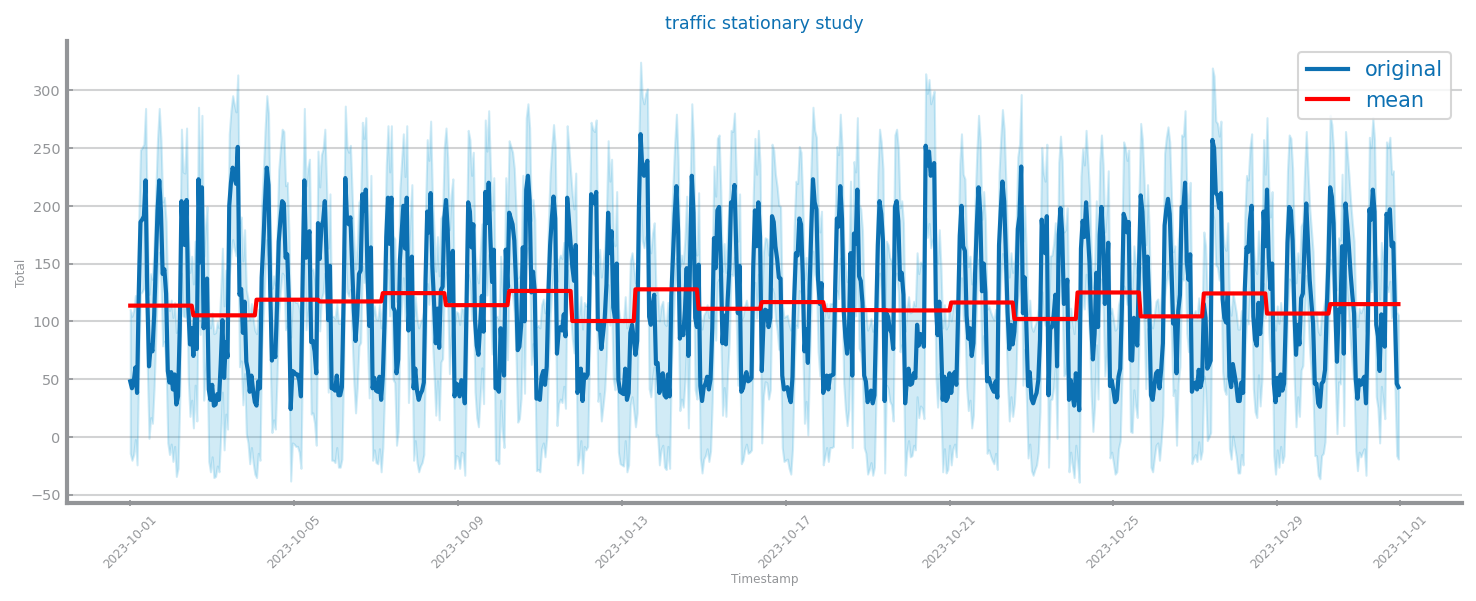

In [27]:
### numeros de BINS e o mesmo que o tamanho de cada janela?
### qual e o numero adequado
BINS = 20
mean_line: list[float] = []

for i in range(BINS):
    segment: pd.Series = series[i * n // BINS : (i + 1) * n // BINS]
    mean_value: list[float] = [segment.mean()] * (n // BINS)
    mean_line += mean_value
mean_line += [mean_line[-1]] * (n - len(mean_line))

figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT))
dslabs.plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
    show_stdev=True,
)
n: int = len(series)
plot(series.index, mean_line, "r-", label="mean")
legend()
savefig("../forecasting_services/data_profilling_images/stationarity_study_2", bbox_inches='tight')
show()

## Augmented Dickey-Fuller test
- More precise way to verify the stationarity of a series.
<br>It determines how strongly a time series is defined by a trend: if it's true, then the series is non-stationary.<br>

In this manner, we have two cases:
1. p-value <= 0.05 : the series is stationary, meaning its values do not depend on time;
2. p-value > 0.05 : the series is non-stationary, meaning it shows a time-dependent structure.

In [ ]:
print(f"The series {('is' if dslabs.eval_stationarity(series) else 'is not')} stationary")